In [1]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
# import rtree, pygeos, fiona
# import netCDF4
# import xarray as xr
# import dask

In [2]:
import re
import pyproj

In [10]:
from import_functions import get_modis_filedata, get_modis_meshgrid
# And change jupyter settings to auto-reload these functions before each instance running them
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
plt.rcParams.update({'font.size': 18})
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [135]:
repo_path = Path('/Users/etriesch/dev/forest-biomass-modeling/')
data_path = repo_path / 'data/'
# data_clean_path = repo_path / 'data/clean/'
geo_crs = 'epsg:4326'
proj_crs = '+proj=cea'

In [136]:
# contiguous US mask
min_lat, max_lat = 20, 48
min_lon, max_lon = -140, -60
min_y, max_y = 996, 1675
min_x, max_x = 940, 2884

# Read in data

In [137]:
# get filenames
lst_path = data_path / 'lst'
files = [f for f in os.listdir(lst_path) 
           if f.endswith('.hdf')]
files.sort()
print('files to read:', len(files))

files to read: 214


In [160]:
def readin_and_subset_modis(files, ds_start=9, ds_len=7):
    pdfs = pd.DataFrame(columns=('lat', 'lon', 'date', 'prop'))
    for f in tqdm(files):

        # read file
        prop, hdf = get_modis_filedata(str(lst_path / f), 'LST_Day_CMG')
        # get lat/lon
        xv, yv = get_modis_meshgrid(hdf, prop)
        lon, lat = xv / 10e5, yv / 10e5
        # stack data
        lat, lon, prop = lat.reshape(-1), lon.reshape(-1), prop.reshape(-1)
        df_prop = np.array([lat, lon, prop]).T
        # subset data
        df_sub = df_prop
        df_sub = df_sub[(df_sub[:,1] >= min_lon) & (df_sub[:,1] <= max_lon),:]
        df_sub = df_sub[(df_sub[:,0] >= min_lat) & (df_sub[:,0] <= max_lat),:]
        # make dataframe
        pdf = pd.DataFrame(df_sub, columns=('lat', 'lon', 'prop'))
        pdf['date_string'] = f[ds_start:ds_start+ds_len]
        pdfs = pd.concat([pdfs, pdf])
    
    return pdfs    

In [144]:
ds_start = 9
ds_len = 7
f = files[0]

pdfs = pd.DataFrame(columns=('lat', 'lon', 'date', 'prop'))
for f in tqdm(files[0:5]):

    # read file
    prop, hdf = get_modis_filedata(str(lst_path / f), 'LST_Day_CMG')

    # get lat/lon
    xv, yv = get_modis_meshgrid(hdf, prop)
    lon, lat = xv / 10e5, yv / 10e5

    # get date
    date = f[ds_start:ds_start+ds_len]

    # stack data
    lat, lon, prop = lat.reshape(-1), lon.reshape(-1), prop.reshape(-1)

    df_prop = np.array([lat, lon, prop]).T

    # subset data
    df_sub = df_prop
    df_sub = df_sub[(df_sub[:,1] >= min_lon) & (df_sub[:,1] <= max_lon),:]
    df_sub = df_sub[(df_sub[:,0] >= min_lat) & (df_sub[:,0] <= max_lat),:]

    # make dataframe
    pdf = pd.DataFrame(df_sub, columns=('lat', 'lon', 'prop'))
    pdf['date_string'] = date
    pdfs = pd.concat([pdfs, pdf])

100%|█████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


# Clean and subset

In [161]:
lst_raw = readin_and_subset_modis(files[0:5])

100%|█████████████████████████████████████████████| 5/5 [00:08<00:00,  1.71s/it]


In [162]:
lst = lst_raw
lst['date'] = pd.to_datetime(lst.date_string.str[0:7], format='%Y%j')
lst['year'] = lst.date.dt.year

In [163]:
# set outlier as 5 times the 75th percentile
PCTL, OUTL = 0.75, 3
pctl_colname = 'pctl'+str(int(PCTL*100))
lst[pctl_colname] = lst.prop.quantile(PCTL)
print('Outlier threshold:', (OUTL * lst[pctl_colname]).drop_duplicates().values)
lst['drop_outlier'] = lst.prop >= OUTL * lst[pctl_colname]
print(f'Outliers dropped: {lst.loc[lst.drop_outlier].shape[0]} ({lst.loc[lst.drop_outlier].shape[0] / lst.shape[0]:0.2%})')

Outlier threshold: [44790.]
Outliers dropped: 0 (0.00%)


In [164]:
# drop outliers
lst = lst.loc[~lst.drop_outlier]

# Create analytical columns

# Combine analysis datasets
Annual data!

# Write data to computer

In [22]:
# overall
filename = 'lst_cln.csv'
filepath = data_clean_path / filename
filepath.parent.mkdir(parents=True, exist_ok=True)

lst.to_csv(filepath, index=False)

# Visualize

In [172]:
lst_sub = lst.loc[lst.date_string=='2004061']

/Users/etriesch/dev/forest-biomass-modeling/venv/forest-biomass-modeling/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


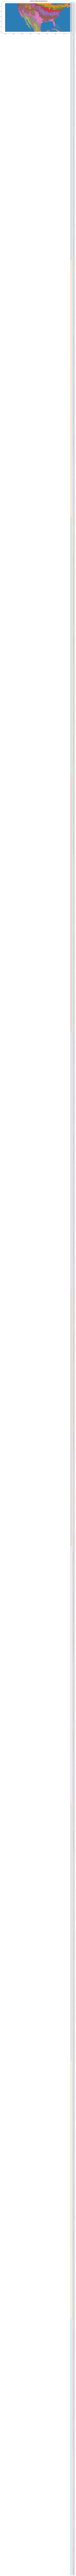

In [174]:
# Visualize
# chlorophyl - pacific mean
geometry = [Point(xy) for xy in zip(lst_sub['lon'], lst_sub['lat'])]
gp = gpd.GeoDataFrame(lst_sub, crs=geo_crs, geometry=geometry)
fig,ax = plt.subplots(figsize=(20,10))
gp.plot(ax=ax, column='prop', markersize=0.1, legend=True)
plt.title('Land surface temperature')
plt.show()